<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [220]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score,precision_recall_curve ,f1_score, roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
data = pd.read_csv('/datasets/Churn.csv')

In [221]:
data.shape

(10000, 14)

In [222]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [224]:
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Заполним пустые ячейки медианными значениями

In [225]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int64')

Закодируем категориальные признаки, чтобы не попасть в дамми-ловушку, применим аргумент drop_first функции pd.get_dummies()

In [226]:
data_ohe = pd.get_dummies(data, drop_first=True)

Выборки (обучающая, тестовая, валидная)
В нашем случае, нет отдельного файла с тестовой,тренировочной и валидной выборкой, поэтому мы их будем создавать сами. Поделим cначала на обучающую и промежуточную, а потом промежуточную поделим на валидную и тестовую.

In [227]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [228]:
features_train, features_inter, target_train, target_inter = train_test_split(
    features.copy(), 
    target.copy(), 
    test_size=0.4, 
    random_state=12345)

Теперь промежуточную поделим пополам

In [229]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_inter.copy(),
    target_inter.copy(),
    test_size=0.5,
    random_state=12345)

Тренировочная выборка у нас с такой размерностью

In [230]:
features_train.shape

(6000, 11)

Тестовая и валидная такая:

In [231]:
features_valid.shape

(2000, 11)

Масштабирование
Стандартизируем численные признаки при помощи StandardScaler

In [232]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]  = scaler.transform(features_valid[numeric])
features_test[numeric]  = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

Выводы:


Выявили, что есть пустоты по полю Tenure. Для более корректной последюущей работы мы заполнили их медианным значеним по столбцу;

Явных дубликатов по полю нами обнаружено не было;
Воспользовавшись техников One-hot-encoding мы преобразовали категориальные признаки в численные. Также, чтобы не попасть в дамми-ловушку мы вызовом функции pd.get_dummies() c аргументом drop_first = True удалили первую колонку;

У нас только один файл(а не три), мы его честно поделили на три части. Сначала общую поделили на тестовую и промежуточную. Поделили в соотношении 40/60. Всё таки учебная выборка должна быть больше остальных. Далее промежуточную поделили пополам - на валидную и тестовую



## Исследование задачи

Так как в нашем случае, стоит задача на классификацию, то наш выбор будет ограничиваться вот такими моделями: Дерево решений,Случайный лес, Логическая регрессия 

In [233]:
data_ohe['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

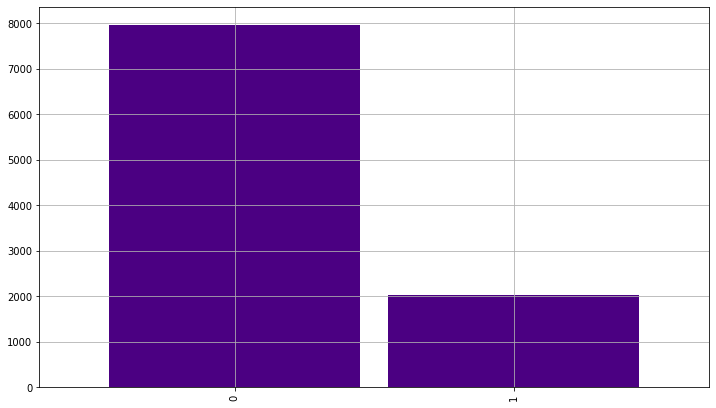

In [234]:
data_ohe['Exited'].value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    );
   

Как мы видим порядка 80 процентов данных по пользователям оставшимся, и только 20 ушедших, что хорошо для банка но не есть отлично для нас с точки зрения построяния модели. Протестируем на разных моделях.

# Дерево решений 

Подберем гиперпараметры

In [235]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth,  class_weight='balanced') 
    model.fit(features_downsampled, target_downsampled) 
    predictions_valid = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions_valid) 
    f1 = f1_score(target_valid , predictions_valid)
    print('max_depth =', depth, ':', result)
    print('f1_score =',f1)
    print()

max_depth = 1 : 0.7405
f1_score = 0.5061845861084681

max_depth = 2 : 0.749
f1_score = 0.5394495412844036

max_depth = 3 : 0.768
f1_score = 0.5555555555555556

max_depth = 4 : 0.7205
f1_score = 0.5360995850622406

max_depth = 5 : 0.8
f1_score = 0.5943204868154158

max_depth = 6 : 0.775
f1_score = 0.576271186440678

max_depth = 7 : 0.735
f1_score = 0.5276292335115865

max_depth = 8 : 0.732
f1_score = 0.5214285714285715

max_depth = 9 : 0.7165
f1_score = 0.5099394987035436



Лучшее значение достигается при глубине дерева  = 5

In [236]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth = 5) 
model_dt.fit(features_train,target_train) 
predictions_valid_dt = model_dt.predict(features_valid) 
print('F1:',f1_score(target_valid, predictions_valid_dt))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt))

F1: 0.5406249999999999
ROC_AUC 0.8221680508592478


# Случайный лес 

Подберем гиперпараметры

In [237]:
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 5):
    for sample in range(2,5):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = sample)
            model.fit(features_downsampled, target_downsampled) 
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid , predictions_valid)
            if result > best_result:
                best_result = result
                best_est = est
                best_depth = depth
                best_split = sample


print("f1_score наилучшей модели на валидационной выборке:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)
print("Минимальное количество примеров для разделения:",best_split)

f1_score наилучшей модели на валидационной выборке: 0.6092184368737475
Количество деревьев: 10
Максимальная глубина: 10
Минимальное количество примеров для разделения: 2


In [238]:
model_rf = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=10, min_samples_split = 2)
model_rf.fit(features_train, target_train) 
predictions_valid_rf = model_rf.predict(features_valid)
print('F1:',f1_score(target_valid, predictions_valid_rf))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt)) 

F1: 0.5891238670694864
ROC_AUC 0.8221680508592478


# Логистическая регрессия

In [239]:
model_lr = LogisticRegression(random_state=12345) 
model_lr.fit(features_train, target_train) 
model_lr.score(features_valid, target_valid)
predictions_valid_lr = model_lr.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_lr))
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_lr))

F1: 0.33108108108108103
ROC_AUC 0.7588057029137607


Во всех трех моделях не достигается параметр F1

# Матрица ошибок, плотность, точность, F1 score, roc_auc


Лучшее значение accuracy мы получили на модели случайного леса в регрессии, рассчитаем необходимые величины для неё.

Рассчитаем матрицу решений

In [240]:
confusion_matrix(target_valid, predictions_valid_rf)

array([[1533,   49],
       [ 223,  195]])

Рассчитаем плотность и точность

In [241]:
display(recall_score(target_valid, predictions_valid_rf))


0.4665071770334928

In [242]:
display(precision_score(target_valid, predictions_valid_rf))

0.7991803278688525

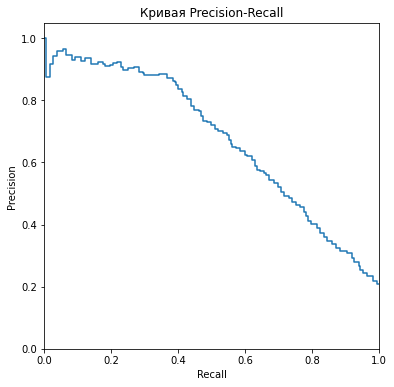

In [243]:
model_rf = RandomForestClassifier(random_state=12345)
model_rf.fit(features_train, target_train) 
probabilities_valid_rf = model_rf.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid_rf[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Вычислим F1-меру

In [244]:
f1_score(target_valid, predictions_valid_rf)

0.5891238670694864

Изобразим противостояние TPR против FPR на графике

In [245]:
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
auc_roc

0.8406361337777266

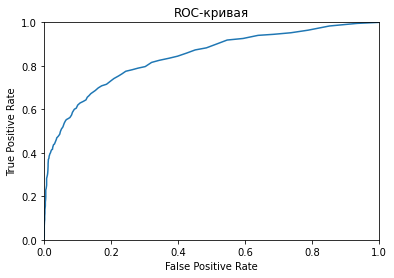

In [246]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.color='indigo',
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Рассмотрев распределение по признаку мы увидели дисбаланс в данных - порядка 1 к 4;

Далее мы посчитали значение accuracy для 3 типов модели (Дерево решений/ Случайный лес/ Логистическая регрессия). По резлуьтатам лучшие показатели были у случайного леса;

Ранее мы выявили, что лучший результат показывает модель случайного леса, для неё мы решили рассчитать матрицу ошибок, плотность, точность и в завершение построить кривую ошибок.

Построив матрицу ошибок мы получили общее предсавление по неточностям нашей модели.

Перейдя к полноте и точности мы можем утверждать, что полнота в нашей модели достаточно слабая(0,49) - а это означает,что модель плохо ищет положительные объекты, точность тоже находится на хорошем уровне (0,79).
По отдельности полнота и точность не слишком информативны, в идеале необходимо иметь высокие значения обоих. Поэтому мы обратились к показателю f1 (среднегармоническое полноты и точности). Оно показало значение 0.589, то от чего мы будем отталкиваться и что мы будем стремиться увеличить (балансировкой, работой с выборкой, подбором гиперпараметров).

## Борьба с дисбалансом

Для борьбы с дисбалансом мы будем использовать три способа - взвешевание классов, уменьшение(в части положительных) и увеличение(в части отрицательных) выборки.

# взвешивание классов

# Дерево решений .

In [294]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth,  class_weight='balanced') 
    model.fit(features_upsampled, target_upsampled) 
    predictions_valid = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions_valid) 
    f1 = f1_score(target_valid , predictions_valid)
    print('max_depth =', depth, ':', result)
    print('f1_score =',f1)
    print()

max_depth = 1 : 0.7545
f1_score = 0.4994903160040775

max_depth = 2 : 0.765
f1_score = 0.541015625

max_depth = 3 : 0.765
f1_score = 0.541015625

max_depth = 4 : 0.711
f1_score = 0.5277777777777778

max_depth = 5 : 0.8105
f1_score = 0.5963791267305644

max_depth = 6 : 0.7665
f1_score = 0.5581835383159887

max_depth = 7 : 0.773
f1_score = 0.5496031746031745

max_depth = 8 : 0.7615
f1_score = 0.5346341463414634

max_depth = 9 : 0.769
f1_score = 0.5398406374501993



In [248]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth = 5) 
model_dt.fit(features_train,target_train) 
predictions_valid_dt = model_dt.predict(features_valid) 

print('F1:',f1_score(target_valid, predictions_valid_dt))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt))

F1: 0.5406249999999999
ROC_AUC 0.8221680508592478


In [249]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth = 5, class_weight='balanced') 
model_dt.fit(features_train,target_train) 
predictions_valid_dt = model_dt.predict(features_valid) 

print('F1:',f1_score(target_valid, predictions_valid_dt))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt))

F1: 0.5963791267305644
ROC_AUC 0.8310244134068074


Показатели после балансировки увеличились


# Случайный лес 

In [250]:
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 5):
    for sample in range(2,5):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = sample)
            model.fit(features_downsampled, target_downsampled) 
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid , predictions_valid)
            if result > best_result:
                best_result = result
                best_est = est
                best_depth = depth
                best_split = sample


print("f1_score наилучшей модели на валидационной выборке:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)
print("Минимальное количество примеров для разделения:",best_split)

f1_score наилучшей модели на валидационной выборке: 0.6092184368737475
Количество деревьев: 10
Максимальная глубина: 10
Минимальное количество примеров для разделения: 2


In [251]:
grid.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=90,
                       random_state=12345)

In [252]:
model_rf = RandomForestClassifier(random_state=12345,n_estimators=10, max_depth=10, min_samples_split = 2)
model_rf.fit(features_train, target_train)
predictions_valid_rf = model_rf.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_rf))
probabilities_valid_rf = model_rf.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_rf))

F1: 0.5891238670694864
ROC_AUC 0.8460226894670304


In [253]:
model_rf = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=10, min_samples_split = 2, class_weight='balanced')
model_rf.fit(features_train, target_train)
predictions_valid_rf = model_rf.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_rf))
probabilities_valid_rf = model_rf.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_rf))

F1: 0.6038647342995168
ROC_AUC 0.8378377560957906


Показатели после балансировки увеличились

# Логистическая регрессия

In [254]:
model_lr = LogisticRegression(random_state=12345) 
model_lr.fit(features_train, target_train) 
predictions_valid_lr = model_lr.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_lr))
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_lr))

F1: 0.33108108108108103
ROC_AUC 0.7588057029137607


In [255]:
model_lr = LogisticRegression(random_state=12345, class_weight='balanced') 
model_lr.fit(features_train, target_train) 
predictions_valid_lr = model_lr.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_lr))
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_lr))

F1: 0.4888507718696398
ROC_AUC 0.7636750766699532


Показатели после балансировки увеличились

# Увеличение выборки

In [256]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    return shuffle(features_upsampled,target_upsampled, random_state=12345)
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [257]:
features_upsampled.shape

(9588, 11)

In [258]:
target_upsampled.value_counts()

0    4804
1    4784
Name: Exited, dtype: int64

Text(0.5, 1.0, 'Exited')

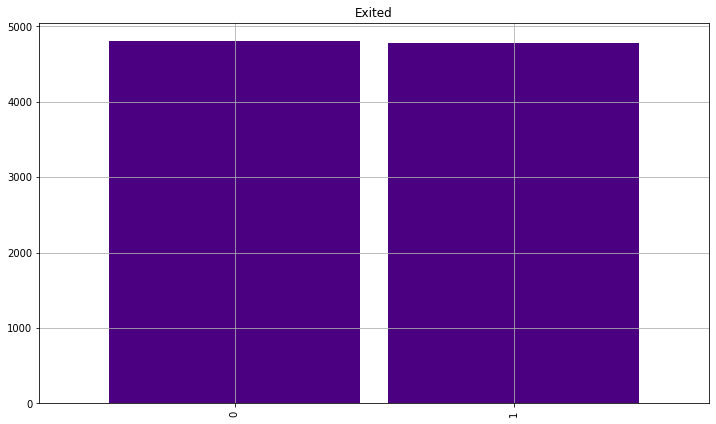

In [298]:
target_upsampled.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    );
plt.title('Exited')

Соотношение улучшилось, проверяем на моделях

# Дерево решений.

In [260]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth) 
    model.fit(features_downsampled, target_downsampled) 
    predictions_valid = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions_valid) 
    f1 = f1_score(target_valid , predictions_valid)
    print('max_depth =', depth, ':', result)
    print('f1_score =',f1)
    print()

max_depth = 1 : 0.7405
f1_score = 0.5061845861084681

max_depth = 2 : 0.749
f1_score = 0.5394495412844036

max_depth = 3 : 0.768
f1_score = 0.5555555555555556

max_depth = 4 : 0.721
f1_score = 0.5357737104825291

max_depth = 5 : 0.8
f1_score = 0.5943204868154158

max_depth = 6 : 0.776
f1_score = 0.5749525616698292

max_depth = 7 : 0.738
f1_score = 0.5304659498207885

max_depth = 8 : 0.734
f1_score = 0.5181159420289856

max_depth = 9 : 0.7345
f1_score = 0.522911051212938



In [261]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth = 5) 
model_dt.fit(features_upsampled,target_upsampled) 
predictions_valid_dt = model_dt.predict(features_valid) 

print('F1:',f1_score(target_valid, predictions_valid_dt))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt))

F1: 0.5963791267305644
ROC_AUC 0.8310244134068074


# Случайный лес.

In [262]:
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 5):
    for sample in range(2,5):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = sample)
            model.fit(features_downsampled, target_downsampled) 
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid , predictions_valid)
            if result > best_result:
                best_result = result
                best_est = est
                best_depth = depth
                best_split = sample


print("f1_score наилучшей модели на валидационной выборке:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)
print("Минимальное количество примеров для разделения:",best_split)

f1_score наилучшей модели на валидационной выборке: 0.6092184368737475
Количество деревьев: 10
Максимальная глубина: 10
Минимальное количество примеров для разделения: 2


In [263]:
grid.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=90,
                       random_state=12345)

In [288]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=10,min_samples_split = 2)
model_rf.fit(features_upsampled, target_upsampled)
predictions_valid_rf = model_rf.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_rf))
probabilities_valid_rf = model_rf.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_rf))

F1: 0.5849462365591399
ROC_AUC 0.8331627036214833


Покзатели уменьшились по сравнению с балансировкой

Логистическая регрессия

In [289]:
model_lr = LogisticRegression(random_state=12345) 
model_lr.fit(features_upsampled, target_upsampled) 
predictions_valid_lr = model_lr.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_lr))
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_lr))

F1: 0.4888507718696398
ROC_AUC 0.7636160997828442


# Уменьшение выборки

In [266]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
  
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [267]:
features_downsampled.shape

(2397, 11)

In [268]:
target_downsampled.value_counts()

0    1201
1    1196
Name: Exited, dtype: int64

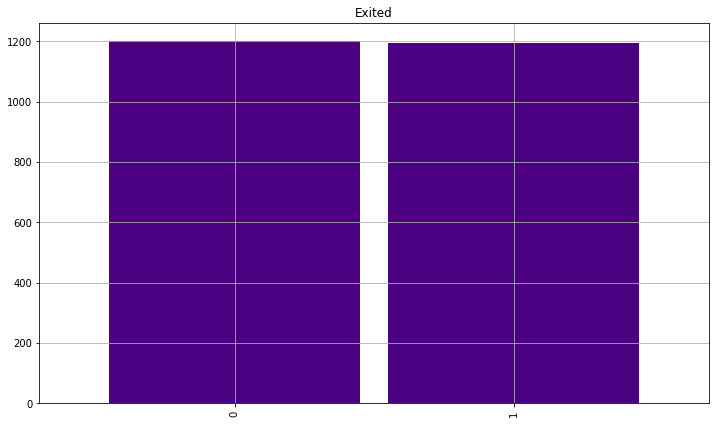

In [301]:
target_downsampled.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='indigo',
    width=0.9,
    figsize=(12,7)
    );
plt.title('Exited');

Соотношение улучшилось.

# Дерево решений .

In [270]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth) 
    model.fit(features_downsampled, target_downsampled) 
    predictions_valid = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions_valid) 
    f1 = f1_score(target_valid , predictions_valid)
    print('max_depth =', depth, ':', result)
    print('f1_score =',f1)
    print()

max_depth = 1 : 0.7405
f1_score = 0.5061845861084681

max_depth = 2 : 0.749
f1_score = 0.5394495412844036

max_depth = 3 : 0.768
f1_score = 0.5555555555555556

max_depth = 4 : 0.721
f1_score = 0.5357737104825291

max_depth = 5 : 0.8
f1_score = 0.5943204868154158

max_depth = 6 : 0.776
f1_score = 0.5749525616698292

max_depth = 7 : 0.738
f1_score = 0.5304659498207885

max_depth = 8 : 0.734
f1_score = 0.5181159420289856

max_depth = 9 : 0.7345
f1_score = 0.522911051212938



In [271]:
model_dt = DecisionTreeClassifier(random_state=12345,max_depth=5) 
model_dt.fit(features_downsampled,target_downsampled) 
predictions_valid_dt = model_dt.predict(features_valid) 

print('F1:',f1_score(target_valid, predictions_valid_dt))
probabilities_valid_dt = model_dt.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_dt))

F1: 0.5943204868154158
ROC_AUC 0.8241029464247908


# Случайный лес.

In [272]:
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 5):
    for sample in range(2,5):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, min_samples_split = sample)
            model.fit(features_downsampled, target_downsampled) 
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid , predictions_valid)
            if result > best_result:
                best_result = result
                best_est = est
                best_depth = depth
                best_split = sample


print("f1_score наилучшей модели на валидационной выборке:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)
print("Минимальное количество примеров для разделения:",best_split)

f1_score наилучшей модели на валидационной выборке: 0.6092184368737475
Количество деревьев: 10
Максимальная глубина: 10
Минимальное количество примеров для разделения: 2


In [273]:
grid.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=90,
                       random_state=12345)

In [290]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=20, min_samples_split =2)
model_rf.fit(features_downsampled, target_downsampled)
predictions_valid_rf = model_rf.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_rf))
probabilities_valid_rf = model_rf.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_rf))

F1: 0.5832549388523048
ROC_AUC 0.8436915901983438


Логистическая регрессия

In [275]:
model_lr = LogisticRegression(random_state=12345) 
model_lr.fit(features_downsampled, target_downsampled) 
predictions_valid_lr = model_lr.predict(features_valid)

print('F1:',f1_score(target_valid, predictions_valid_lr))
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
print("ROC_AUC", roc_auc_score(target_valid, probabilities_valid_lr))

F1: 0.48406546080964685
ROC_AUC 0.7622293868218414


Краткий вывод по третьему шагу.

На первом шаге мы поигрались с взвешиванием классов. Мы посмотрели на то какое значение модель даёт без сбалансированого взвешивании классов и с. У всех моделей за исключением логистической регресии значение F1 и ROC_AUC растет

Далее для того, чтобы объекты редкого класса стали не такими редкими в выборке мы прибегли к увеличению выборки. Достигли соотнеошение близкое 1 к 1.

В результате у если у моделей дерева решений был виден рост и по f1 и roc_auc на 0.1, то по модели случайного леса значение f1 достигло 0.61 а roc_auc 0.84 

Далее мы постарались объекты частого класса сделать не такими частыми в выборке прибегнув уменьшения выборки. Написав функцию и применив её к выборке мы получили распределение ну-почти равное. После чего мы протестировали на новой даунсэмплииованной выборке наши модели.

В результате мы получили, что случайого леса показатели самые лучшие по сравнению с другими f1 0.61 пртив 0.48 и 0.58 и roc_auc 0.84 против  0.76 и вообще по всем моделям лучшие показатели получились именно при увеличении выборки и использовании взвешенных классов.

## Тестирование модели

# Проверяем лучшую модель


Модель с лучшими показателями была случайный лес, с гиперпараметрами что мы нашли сами.

In [295]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=10, min_samples_split = 2, class_weight='balanced')
model_rf.fit(features_upsampled, target_upsampled)
predictions_valid_rf = model_rf.predict(features_test)

print('F1:',f1_score(target_test, predictions_valid_rf))
probabilities_valid_rf = model_rf.predict_proba(features_test)[:, 1]
print("ROC_AUC", roc_auc_score(target_test, probabilities_valid_rf))

F1: 0.608604407135362
ROC_AUC 0.8467239619170973


Для Случайного леса значения оказались самыми лучшими в исследовании и тестовая выборка показала - F1 = 0.61, Roc_auc= 0.85. 
Берем ее в работу

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [х]  Ячейки с кодом расположены в порядке исполнения
- [х]  Выполнен шаг 1: данные подготовлены
- [х]  Выполнен шаг 2: задача исследована
    - [х]  Исследован баланс классов
    - [х]  Изучены модели без учёта дисбаланса
    - [х ]  Написаны выводы по результатам исследования
- [х]  Выполнен шаг 3: учтён дисбаланс
    - [х]  Применено несколько способов борьбы с дисбалансом
    - [х]  Написаны выводы по результатам исследования
- [х]  Выполнен шаг 4: проведено тестирование
- [х]  Удалось достичь *F1*-меры не менее 0.59
- [х]  Исследована метрика *AUC-ROC*